<a href="https://colab.research.google.com/github/Goshikhar23/DL-back-to-the-basics/blob/master/gd_variants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors

from matplotlib import animation, rc, cm
from IPython.display import HTML

from mpl_toolkits.mplot3d import Axes3D

# SN class

In [ ]:
class SN():

  def __init__(self, w_init, b_init, algo):     # For different w_init and b_init we want to plot different converging points
    self.w = w_init
    self.b = b_init
    self.w_h = []
    self.b_h = []     # History
    self.e_h = []
    self.algo = algo

  def sigmoid(self, x, w=None, b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    return 1/(1+np.exp(-(w*x+b)))

  def error(self, X, Y, w=None, b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    err = 0
    for x, y in zip(X, Y):
      err+= 0.5 * (self.sigmoid(x, w, b) - y) ** 2
    return err
  
  def grad_w(self, x, y, w=None, b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    y_pred = self.sigmoid(x, w, b)
    return (y_pred - y) * y_pred * (1 - y_pred) * x
  
  def grad_b(self, x, y, w=None, b=None):
    if w is None:
      w = self.w
    if b is None:
      b = self.b
    y_pred = self.sigmoid(x, w, b)
    return (y_pred - y) * y_pred * (1 - y_pred) 

  def fit(self, X, Y, epochs=100, eta=0.01, gamma=0.9, mini_batch_size=100, eps=1e-8, beta=0.9, beta1=0.9, beta2=0.9):
    self.w_h = []
    self.b_h = []     
    self.e_h = []
    self.X = X
    self.Y = Y

    if self.algo == 'GD':
      for i in range(epochs):
        dw, db = 0,0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x, y)
        self.w -= eta * dw / X.shape[0]
        self.b -= eta * db / X.shape[0]
        self.append_log()
      
    elif self.algo == "Momentum":
      v_w_prev, v_b_prev = 0, 0
      for i in range(epochs):
        dw, db = 0,0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x, y)
        # Different update
        v_w = gamma * v_w_prev + eta * dw
        v_b = gamma * v_b_prev + eta * db
        self.w = self.w - v_w
        self.b = self.b - v_b
        v_w_prev = v_w
        v_b_prev = v_b
        self.append_log()

    elif self.algo == 'NAG':
      v_w_prev, v_b_prev = 0, 0
      for i in range(epochs):
        dw, db = 0,0
        v_w = gamma * v_w_prev
        v_b = gamma * v_b_prev
        
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y, self.w - v_w, self.b - v_b)
          db += self.grad_b(x, y, self.w - v_w, self.b - v_b)
        
        v_w = gamma * v_w_prev + eta * dw
        v_b = gamma * v_b_prev + eta * db
        self.w = self.w - v_w
        self.b = self.b - v_b
        v_w_prev = v_w
        v_b_prev = v_b
        self.append_log()

    elif self.algo == 'MiniBatch':
      for i in range(epochs):
        dw, db = 0,0
        points_seen = 0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x, y)
          points_seen+=1
        if(points_seen % mini_batch_size == 0):
          self.w -= eta * dw / X.shape[0]
          self.b -= eta * db / X.shape[0]
          self.append_log()
          dw, db = 0, 0

    elif self.algo == 'AdaGrad':
      v_w, v_b = 0, 0
      for i in range(epochs):
        dw, db = 0, 0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x, y)
        
        v_w += dw**2
        v_b += db**2
        
        self.w -= (eta / np.sqrt(v_w) + eps) * dw
        self.b -= (eta / np.sqrt(v_b) + eps) * db
        self.append_log()

    elif self.algo == 'RMSProp':
      v_w, v_b = 0, 0
      for i in range(epochs):
        dw, db = 0, 0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x, y)
        
        v_w += beta * v_w + (1 - beta) * dw**2
        v_b += beta * v_b + (1 - beta) * db**2
        
        self.w -= (eta / np.sqrt(v_w) + eps) * dw
        self.b -= (eta / np.sqrt(v_b) + eps) * db
        self.append_log()

    elif self.algo == 'Adam':
      v_w, v_b = 0, 0
      m_w, m_b = 0, 0
      num_updates = 0
      for i in range(epochs):
        dw, db = 0, 0
        for x, y in zip(X, Y):
          dw += self.grad_w(x, y)
          db += self.grad_b(x, y)
          num_update += 1
          m_w = beta1 * m_w + (1- beta1) * dw
          m_b = beta1 * m_b + (1- beta1) * db 
          v_w = beta2 * v_w + (1 - beta2) * dw**2
          v_b = beta2 * v_b + (1 - beta2) * db**2
          m_w_c = m_w / (1- np.power(beta1, num_updates))
          m_w_b = m_b / (1- np.power(beta1, num_updates))
          v_w_c = v_w / (1- np.power(beta2, num_updates))
          v_w_c = v_w / (1- np.power(beta2, num_updates))
          self.w -= (eta / np.sqrt(v_w_c) + eps) * m_w_c
          self.b -= (eta / np.sqrt(v_b_c) + eps) * m_b_c
          self.append_log()

  def append_log(self):
    self.w_h.append(self.w)
    self.b_h.append(self.b)
    self.e_h.append(self.error(self.X, self.Y))   

  

# Data, algo and Hyperparameter tuning

In [ ]:
X = np.asarray([0.5, 0.25])
Y = np.asarray([0.2, 0.9])

algo = 'GD'

w_init = -2
b_init = -2

epochs =1000
eta =1

w_min =-7
w_max = 5

b_min = -5
b_max = 5

animation_frames = 20
plot_3d = True
plot_2d = False

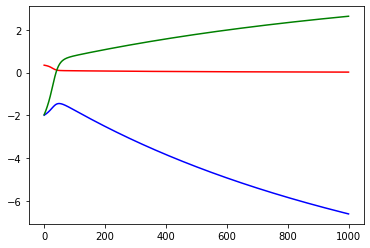

In [ ]:
sn = SN(w_init, b_init, algo)
sn.fit(X, Y, epochs=epochs, eta=eta)
plt.plot(sn.e_h, 'r')
plt.plot(sn.w_h, 'b')
plt.plot(sn.b_h, 'g')
plt.show()